<a href="https://colab.research.google.com/github/akashmavle5/--akash/blob/main/rapids_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Sun Apr 18 11:53:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup:
Set up script installs
1. Install most recent Miniconda release compatible with Google Colab's Python install  (3.7.10)
1. removes incompatible files
1. Install RAPIDS' current stable version of its libraries, including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. xgboost
1. Set necessary environment variables
1. Copy RAPIDS .so files into current working directory, a workaround for conda/colab interactions


In [2]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 213 (delta 22), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (213/213), 64.29 KiB | 9.18 MiB/s, done.
Resolving deltas: 100% (84/84), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals

# cuDF and cuML Examples #

Now you can run code! 

What follows are basic examples where all processing takes place on the GPU.

#[cuDF](https://github.com/rapidsai/cudf)#

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

_Note_: You must import nvstrings and nvcategory before cudf, else you'll get errors.

In [4]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
tips_df = cudf.read_csv(io.StringIO(content))
tips_df['tip_percentage'] = tips_df['tip']/tips_df['total_bill']*100

# display average tip by dining party size
print(tips_df.groupby('size').tip_percentage.mean())

size
6    15.622920
1    21.729202
4    14.594901
3    15.215685
2    16.571919
5    14.149549
Name: tip_percentage, dtype: float64


#[cuML](https://github.com/rapidsai/cuml)#

This snippet loads a 

As above, all calculations are performed on the GPU.

In [5]:
import cuml

# Create and populate a GPU DataFrame
df_float = cudf.DataFrame()
df_float['0'] = [1.0, 2.0, 5.0]
df_float['1'] = [4.0, 2.0, 1.0]
df_float['2'] = [4.0, 2.0, 1.0]

# Setup and fit clusters
dbscan_float = cuml.DBSCAN(eps=1.0, min_samples=1)
dbscan_float.fit(df_float)

print(dbscan_float.labels_)

0    0
1    1
2    2
dtype: int32


In [6]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

In [7]:
n_samples = 100000
n_features = 2

n_clusters = 5
random_state = 0

In [8]:
device_data, device_labels = make_blobs(n_samples=n_samples,
                                        n_features=n_features,
                                        centers=n_clusters,
                                        random_state=random_state,
                                        cluster_std=0.1)

device_data = cudf.DataFrame(device_data)
device_labels = cudf.Series(device_labels)

In [9]:
# Copy dataset from GPU memory to host memory.
# This is done to later compare CPU and GPU results.
host_data = device_data.to_pandas()
host_labels = device_labels.to_pandas()

In [10]:
%%time
kmeans_sk = skKMeans(init="k-means++",
                     n_clusters=n_clusters,
                     n_jobs=-1,
                    random_state=random_state)

kmeans_sk.fit(host_data)

/usr/local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


CPU times: user 604 ms, sys: 6.93 ms, total: 611 ms
Wall time: 453 ms


In [11]:
%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=40,
                       random_state=random_state)

kmeans_cuml.fit(device_data)

CPU times: user 527 ms, sys: 72 ms, total: 599 ms
Wall time: 602 ms


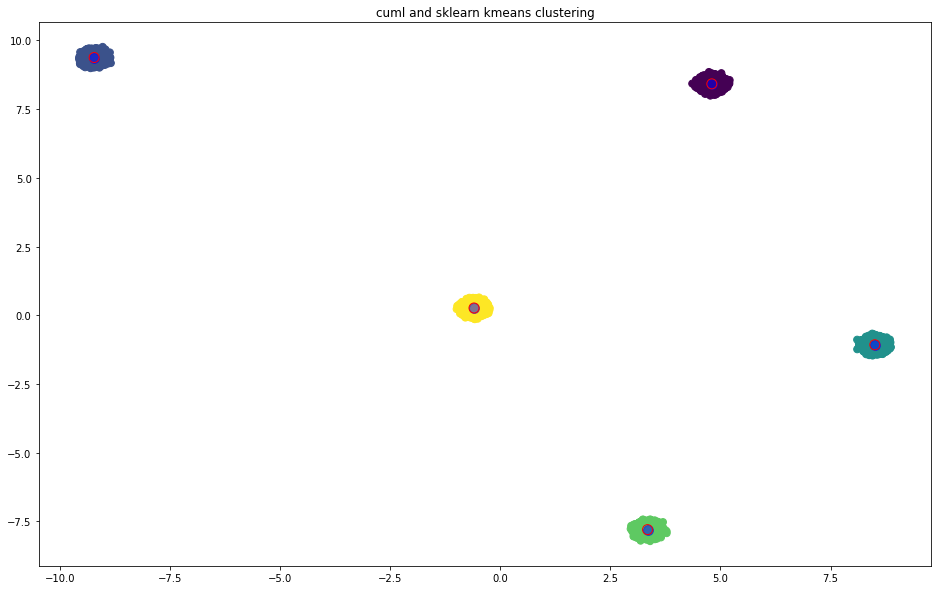

In [12]:
fig = plt.figure(figsize=(16, 10))
plt.scatter(host_data.iloc[:, 0], host_data.iloc[:, 1], c=host_labels, s=50, cmap='viridis')

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[0].values), 
            cupy.asnumpy(centers_cuml[1].values), 
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

In [13]:
%%time
cuml_score = adjusted_rand_score(host_labels, kmeans_cuml.labels_.to_array())
sk_score = adjusted_rand_score(host_labels, kmeans_sk.labels_)

CPU times: user 33.4 ms, sys: 3.89 ms, total: 37.3 ms
Wall time: 43.4 ms


In [14]:
threshold = 1e-4

passed = (cuml_score - sk_score) < threshold
print('compare kmeans: cuml vs sklearn labels_ are ' + ('equal' if passed else 'NOT equal'))

compare kmeans: cuml vs sklearn labels_ are equal


# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib